## These are the libraries I used:

In [0]:
#Uncomment to get obspy and update necessary packages
#!pip install --upgrade seaborn==0.9.0

#This line has to be executed every runtime. Be sure to restart runtime as well.
!pip install obspy 

     |████████████████████████████████| 24.7MB 1.7MB/s 
  Created wheel for obspy: filename=obspy-1.2.1-cp36-cp36m-linux_x86_64.whl size=21663439 sha256=ac256279a003b5db5865d34f274c51610002f5abfa09c601cfff034531e78880
  Stored in directory: /root/.cache/pip/wheels/99/1b/9d/ada1c7af86c92811628dc58568bb27f3ffb46ee157e1f1e8db
Successfully built obspy


In [0]:
from obspy import read,Stream, Trace
from obspy.core import UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import math as M
import matplotlib
from matplotlib import mlab
from matplotlib.colors import Normalize
import requests
from lxml import html
from scipy import signal
import matplotlib.colors as colors
import datetime

%matplotlib inline

#FFT package
from scipy.fftpack import fft

## Create PSD Plotting function

In [0]:
def psdPlot(st):
  psdAvg = 0
  psdSum = 0
  K=0

  #Create PSD data by processing one second at a time and averaging over the whole mseed file
  for i in range(0,(int(st[0].stats.endtime.timestamp)-int(st[0].stats.starttime.timestamp))):
    t_start = st[0].stats.starttime+i
    t_end = t_start+1
    sliced = st.slice(t_start, t_end)
    #sliced.plot()
    x = (sliced[0].data)*np.hanning(len(sliced[0].data))
    xfft = 2*np.square(fft(x,64000))/(len(x)*fs)
    fre = np.linspace(1,fs,64000)
    data_db = 10*np.log10(np.abs(xfft))+169-128.9 #This has to be summed together and divided by K 
    psdSum += data_db
    K+=1
  psdAvg = psdSum/K
  fig, host = plt.subplots(figsize=(18,9))
  host.plot(fre[0:32000], psdAvg[0:32000],label='PSD')

  #Pick the max and min frequencies that should be displayed
  fmin=0
  fmax=15000

  #Show average PSD line in red
  matplotlib.axes.Axes.axhline(self=host,y=psdAvg[fmin:fmax].mean(),xmin=fmin,xmax=fmax,c='red')

  #Some plot formatting commands to make the graph look nice
  host.set_title('Power Spectral Density [dB/Hz] vs. frequency [Hz]',fontsize=30,pad=10,)
  host.tick_params(gridOn=True)
  host.tick_params(axis='x',labelrotation=45)
  host.locator_params(axis='y', nbins=20)
  host.locator_params(axis='x', nbins=15)
  host.tick_params(axis='both', labelsize=15)
  host.set_xlabel('frequency [Hz]', fontsize=20)
  host.set_ylabel('PSD [dB/Hz]', fontsize=20)
  host.set_xlim(fmin,fmax)
  host.set_ylim(psdAvg[fmin:fmax].min()-5,85)

In [0]:
#second version for PSD graphs. Same function but with higher upper bounds on the graph.
def psdPlot2(st):
  psdAvg = 0
  psdSum = 0
  K=0

  #Create PSD data by processing one second at a time and averaging over the whole mseed file
  for i in range(0,(int(st[0].stats.endtime.timestamp)-int(st[0].stats.starttime.timestamp))):
    t_start = st[0].stats.starttime+i
    t_end = t_start+1
    sliced = st.slice(t_start, t_end)
    #sliced.plot()
    x = (sliced[0].data)*np.hanning(len(sliced[0].data))
    xfft = 2*np.square(fft(x,64000))/(len(x)*fs)
    fre = np.linspace(1,fs,64000)
    data_db = 10*np.log10(np.abs(xfft))+169-128.9 #This has to be summed together and divided by K 
    psdSum += data_db
    K+=1
  psdAvg = psdSum/K
  fig, host = plt.subplots(figsize=(18,9))
  host.plot(fre[0:32000], psdAvg[0:32000],label='PSD')

  #Pick the max and min frequencies that should be displayed
  fmin=0
  fmax=15000

  #Show average PSD line in red
  matplotlib.axes.Axes.axhline(self=host,y=psdAvg[fmin:fmax].mean(),xmin=fmin,xmax=fmax,c='red')

  #Some plot formatting commands to make the graph look nice
  host.set_title('Power Spectral Density [dB/Hz] vs. Frequency [Hz]',fontsize=30,pad=10,)
  host.tick_params(gridOn=True)
  host.tick_params(axis='x',labelrotation=45)
  host.locator_params(axis='y', nbins=20)
  host.locator_params(axis='x', nbins=15)
  host.tick_params(axis='both', labelsize=15)  
  host.set_xlabel('frequency [Hz]', fontsize=20)
  host.set_ylabel('PSD [dB/Hz]', fontsize=20)
  host.set_xlim(fmin,fmax)
  host.set_ylim(psdAvg[fmin:fmax].min()-5,100)

## Create Spectrogram Plotting Function

In [0]:
def spectrogram(st,ylims,starttime,endtime):
  t_start = starttime
  t_end = endtime
  sliced = st.slice(t_start, t_end)
  fs = st[0].stats.sampling_rate
  npts = len(sliced[0])
  end = npts / fs
  nfft = int(fs/16)  # number of fft points of each bin
  print(nfft)
  per_lap = 0.90      # percentage of overlap
  nlap = int(nfft * float(per_lap))   # number of overlapped samples

  # using mlab to create the array of spectrogram 
  specgram, freq, time = mlab.specgram(sliced[0].data,NFFT = nfft,Fs = fs,noverlap = nlap, pad_to = None)
  
  #Convert to Decibels
  specgram = 10 * np.log10(specgram) +169-128.9

  #Graph formatting
  fig, host = plt.subplots(figsize=(18,12))
  host.contourf(time,freq,specgram,30,vmin=0, vmax=120)
  host.set_xlabel('time (s)', fontsize=20)
  host.set_ylabel('freq (Hz)', fontsize=20)
  host.set_title('Frequency [Hz] vs. Time [s]',fontsize=30,pad=10,)
  host.locator_params(axis='y', nbins=20)
  host.tick_params(axis='both', labelsize=20)  
  host.locator_params(axis='x', nbins=15)
  host.set_ylim(ylims)

  #Add colorbar legend for sound intensity levels
  fig.colorbar(mappable=matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=specgram.min(),vmax=int(specgram.max())+5),cmap=None),ax=host)

#Part 1: Wind and Rain Noise

## Oregon Shelf Surface Mooring

Request data for time periods where it is:
1. Windy and rainy
2. Rainy, but not windy
3. Windy, but not rainy
4. Not windy and not rainy

In [0]:
data_url_1 = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2018/11/26/OO-HYEA2--YDH-2018-11-26T01:25:00.000000.mseed'#'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T20:00:00.000015.mseed'
data_url_2 = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2019/02/12/OO-HYEA2--YDH-2019-02-12T04:30:00.000000.mseed'
data_url_3 = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2018/12/13/OO-HYEA2--YDH-2018-12-13T10:30:00.000015.mseed'
data_url_4 = 'https://rawdata.oceanobservatories.org/files/CE02SHBP/LJ01D/11-HYDBBA106/2018/04/05/OO-HYEA2--YDH-2018-04-05T11:30:00.000000.mseed'

stWR = read(data_url_1)      #Windy and rainy
stRNW = read(data_url_2)     #Rainy, but not windy
stWNR = read(data_url_3)     #Windy, but not rainy
stNWNR = read(data_url_4)    #Not windy and not rainy

What is the sampling rate?

In [0]:
fs = stWR[0].stats.sampling_rate
print('The sampling rate is '+str(fs/1000)+' kHz.')

The sampling rate is 64.0 kHz.


Plot the spectrogram for windy and rainy:

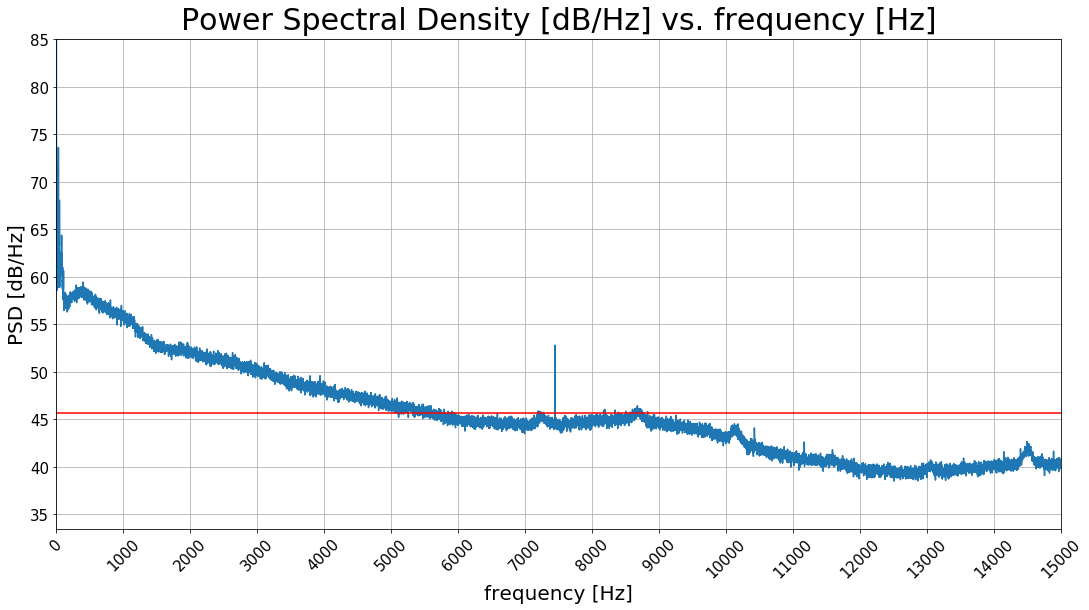

In [0]:
psdPlot(stWR)

Plot the spectrogram for rainy but not windy:

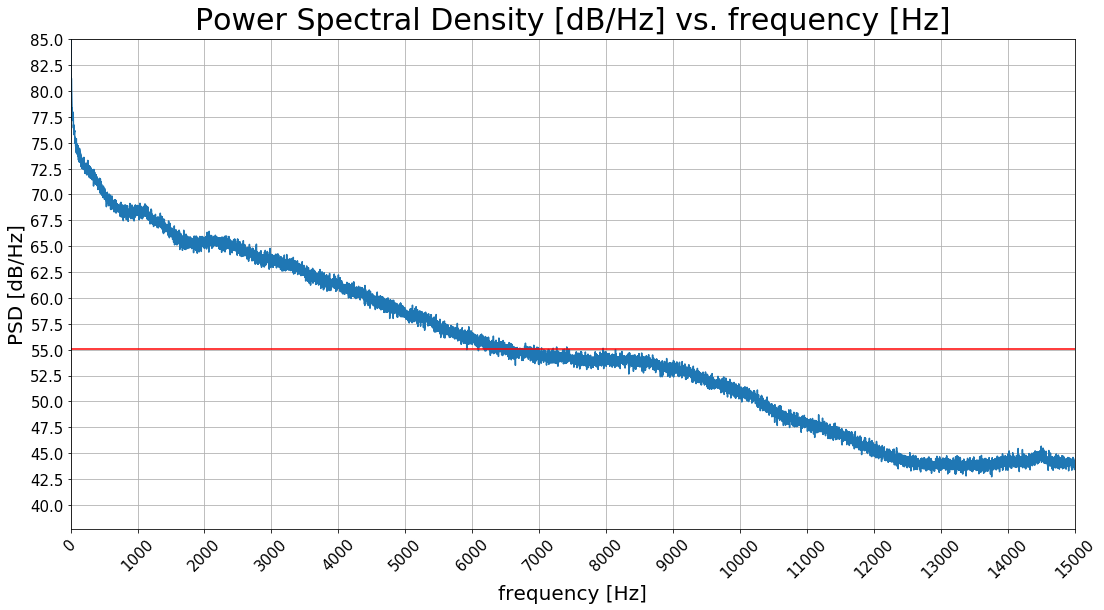

In [0]:
psdPlot(stRNW)

Plot the spectrogram for windy but not rainy:

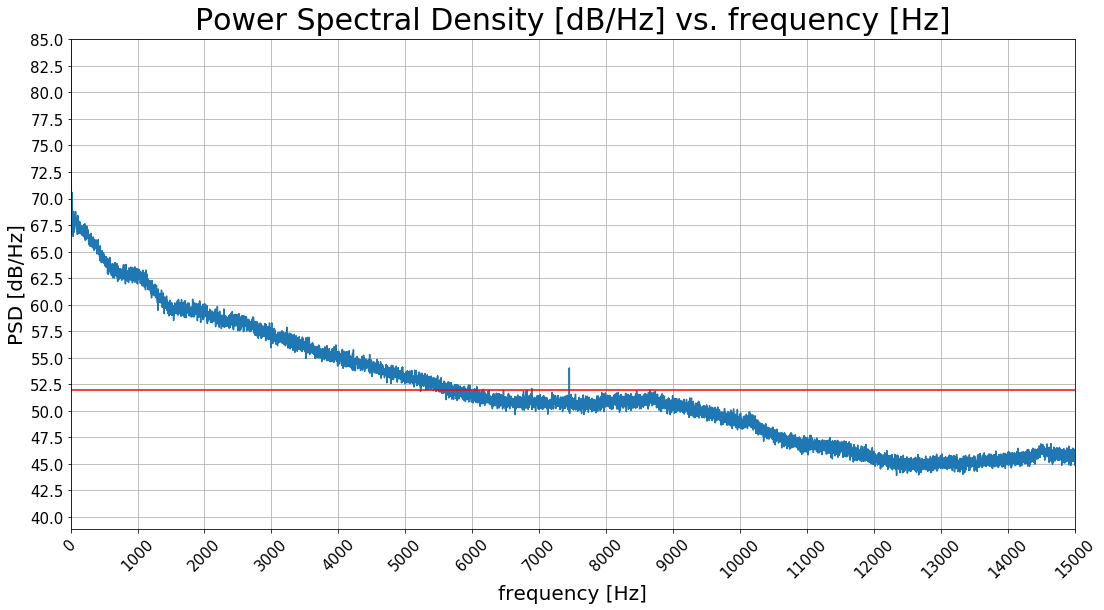

In [0]:
psdPlot(stWNR)

Plot the spectrogram for not windy and not rainy:

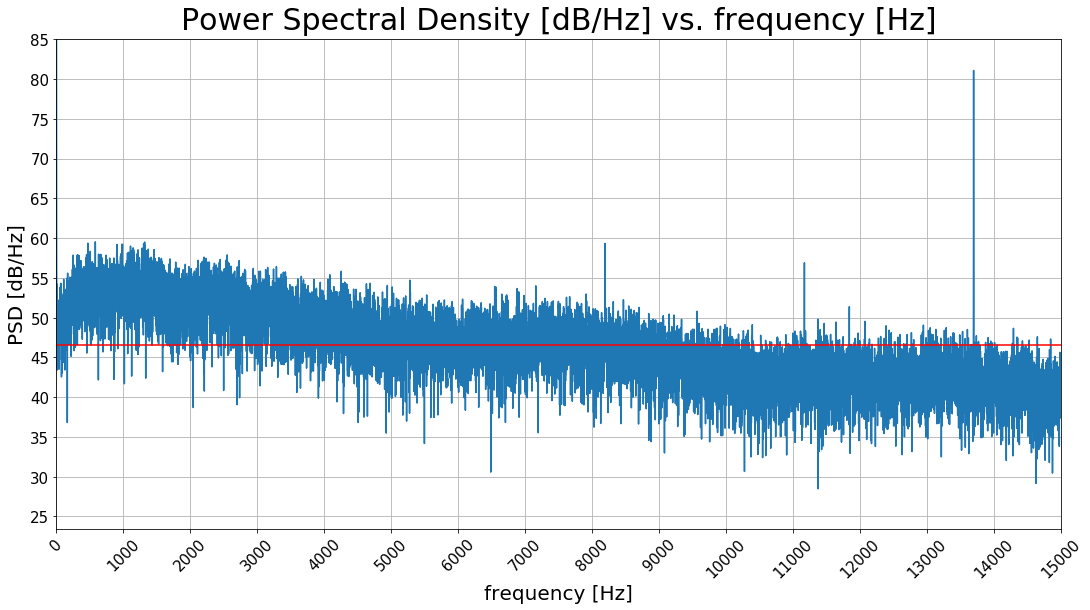

In [0]:
psdPlot(stNWNR)

## Oregon Offshore Surface Mooring

Request data for time periods where it is:
1. Windy and rainy
2. Rainy, but not windy
3. Windy, but not rainy
4. Not windy and not rainy

In [0]:
data_url_5 = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2018/09/15/OO-HYEA1--YDH-2018-09-15T02:05:00.000000.mseed'
data_url_6 = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/01/31/OO-HYEA1--YDH-2019-01-31T22:05:00.000000.mseed'
data_url_7 = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/02/06/OO-HYEA1--YDH-2019-02-06T11:10:00.000000.mseed'
data_url_8 = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2019/02/21/OO-HYEA1--YDH-2019-02-21T08:10:00.000000.mseed'

stWR2 = read(data_url_5)      #Windy and rainy
stRNW2 = read(data_url_6)     #Rainy, but not windy
stWNR2 = read(data_url_7)     #Windy, but not rainy
stNWNR2 = read(data_url_8)    #Not windy and not rainy

Plot the spectrogram for windy and rainy:

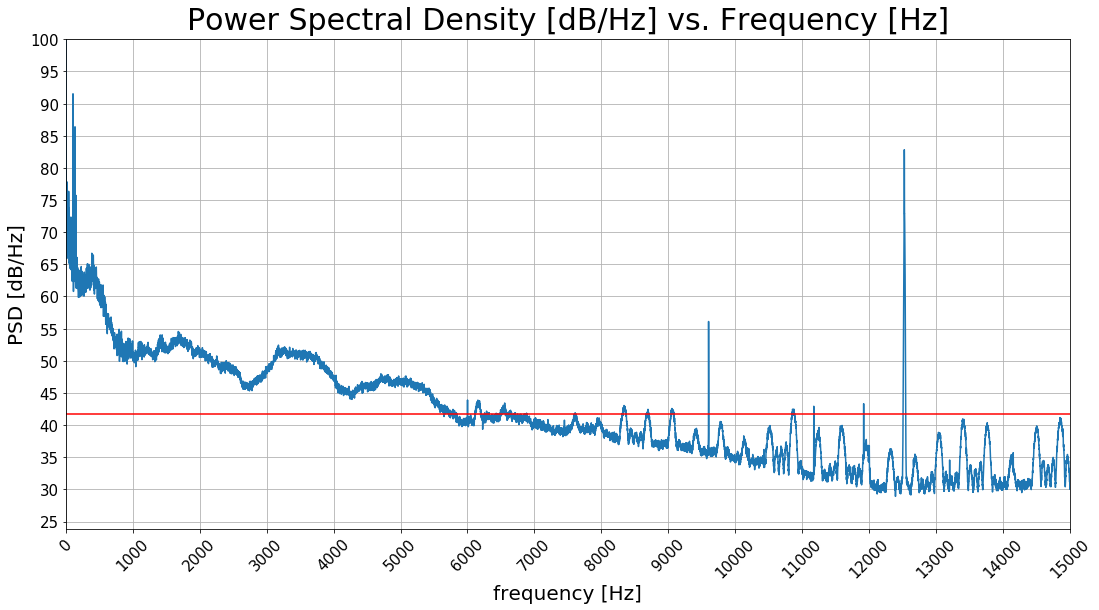

In [0]:
psdPlot2(stWR2)

Plot the spectrogram for rainy but not windy:

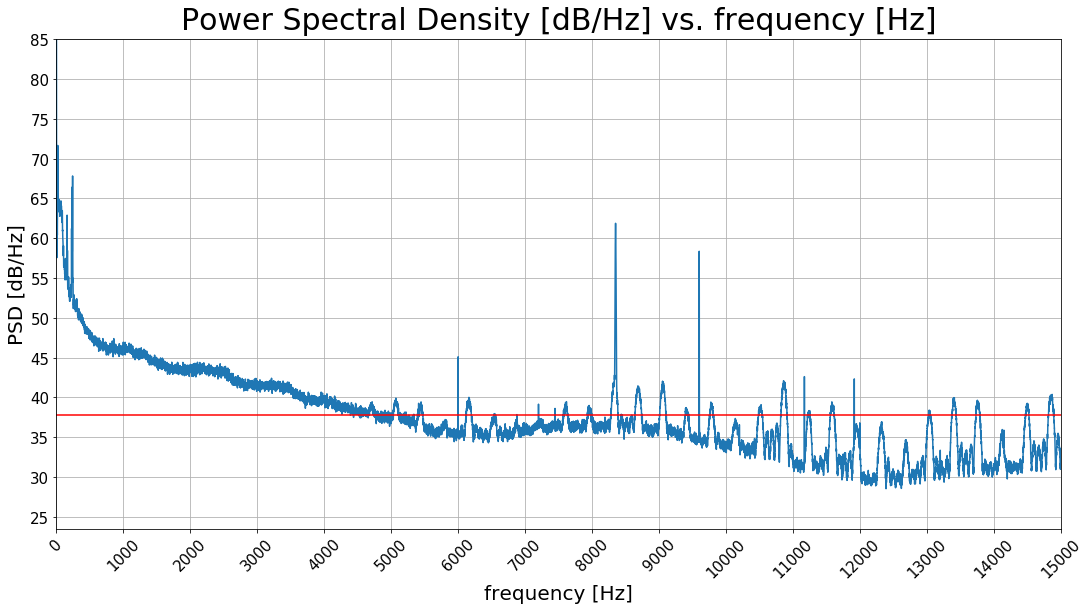

In [0]:
psdPlot(stRNW2)

Plot the spectrogram for windy but not rainy:

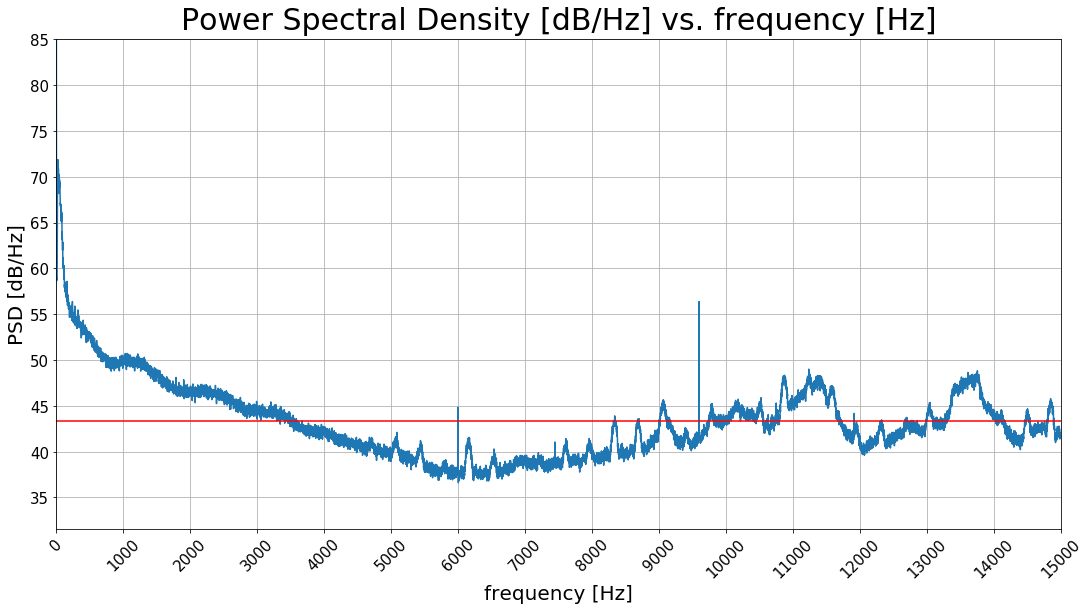

In [0]:
psdPlot(stWNR2)

Plot the spectrogram for not windy and not rainy:

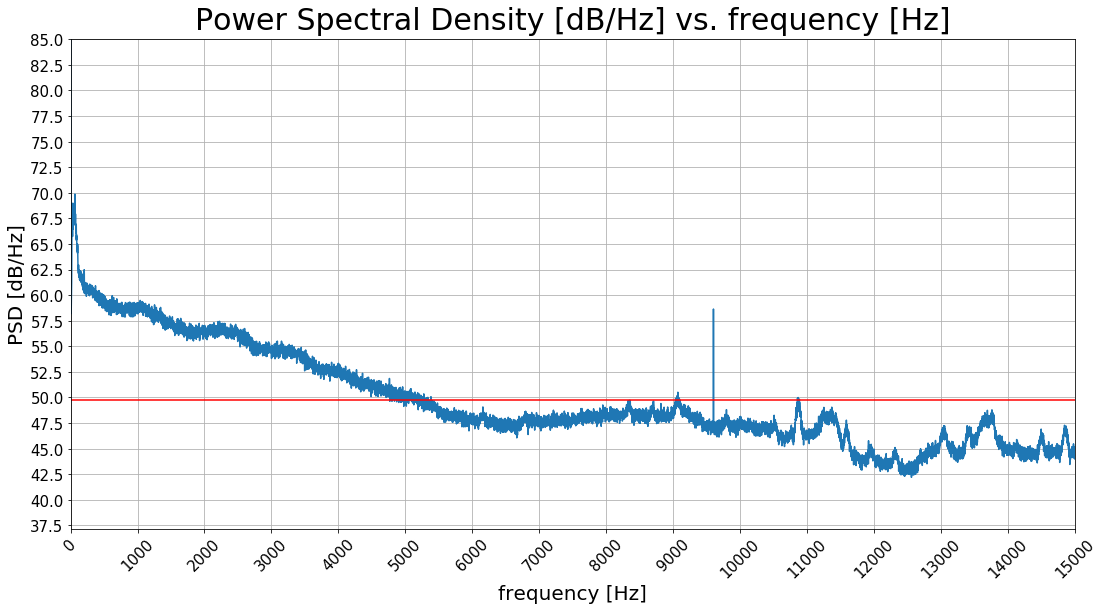

In [0]:
psdPlot(stNWNR2)

#Part 2: Airgun, Marine Mammals, Earthquake/Volcano Noise

Download sound data for marine mammal vocalization, an airgun, and an earthquake/volcanic eruption:

In [0]:
data_url_1 = 'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T05:25:00.001563.mseed'#https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T05:25:00.001563.mseed'#'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T01:50:00.000000.mseed'#'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T00:00:00.000000.mseed'#'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T05:20:00.000000.mseed'  #'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/OO-HYVM1--YDH-2017-10-06T20:00:00.000015.mseed'
data_url_2 = 'https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2019/08/01/OO-AXVM1--YDH-2019-08-01T07:40:00.000000.mseed'
data_url_3 = 'https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2017/04/15/OO-HYEA1--YDH-2017-04-15T14:45:00.000000.mseed' #Axial base seafloor platform 
stMMV = read(data_url_1)      #Marine Mammal Vocalization
stARG = read(data_url_2)     #Airgun noise
stSeis = read(data_url_3)     #Earthquake/volcanic eruption

Marine Mammal Vocalization Spectrogram:

4000


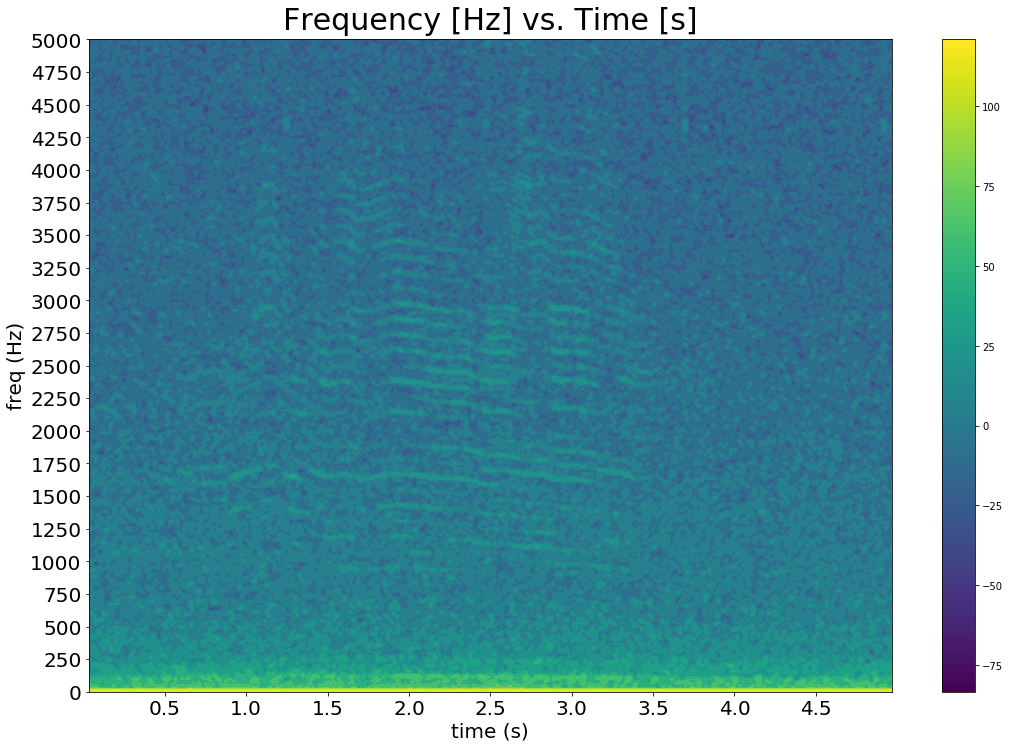

In [0]:
starttime1=stMMV[0].stats.starttime+112
endtime1=stMMV[0].stats.starttime+117
ylims1=(0,5000) #Frequency range of marine mammal vocalization
spectrogram(stMMV,ylims1,starttime1,endtime1)

Airgun noise spectrogram:

4000


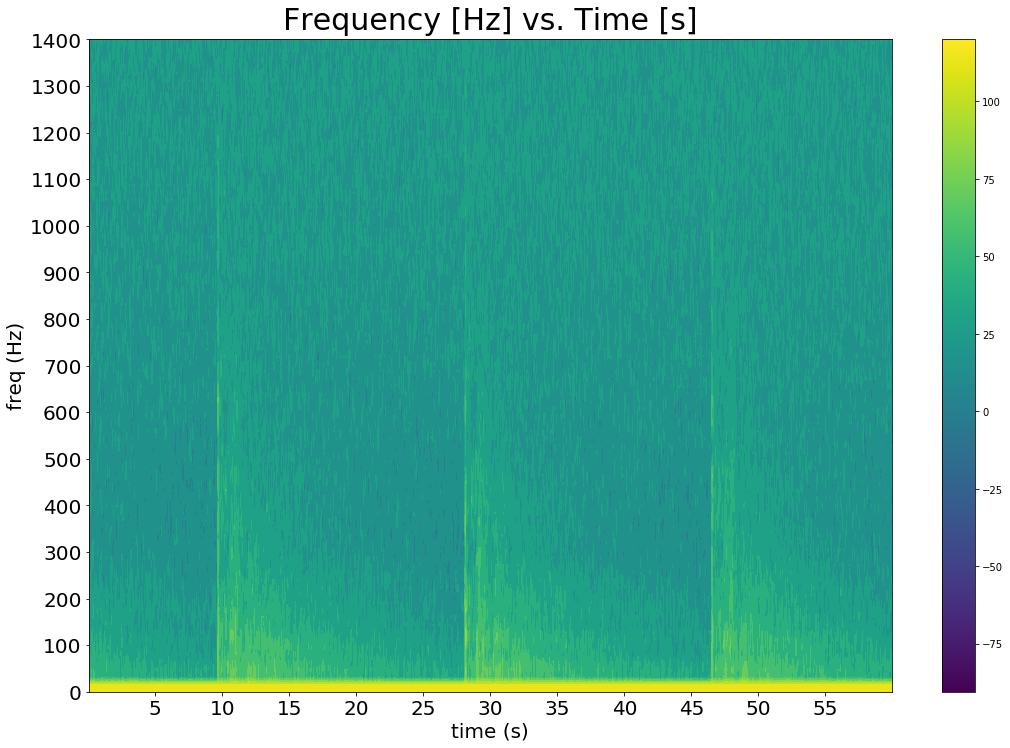

In [0]:
starttime2=stARG[0].stats.starttime
endtime2=stARG[0].stats.starttime+60
ylims2=(0,1400) #Frequency range of seismic activity according to the Wenz curve https://acousticstoday.org/wp-content/uploads/2016/12/Seismic-Surveys.pdf
spectrogram(stARG,ylims2,starttime2,endtime2)

Earthquake/volcanic eruption spectrogram:

4000


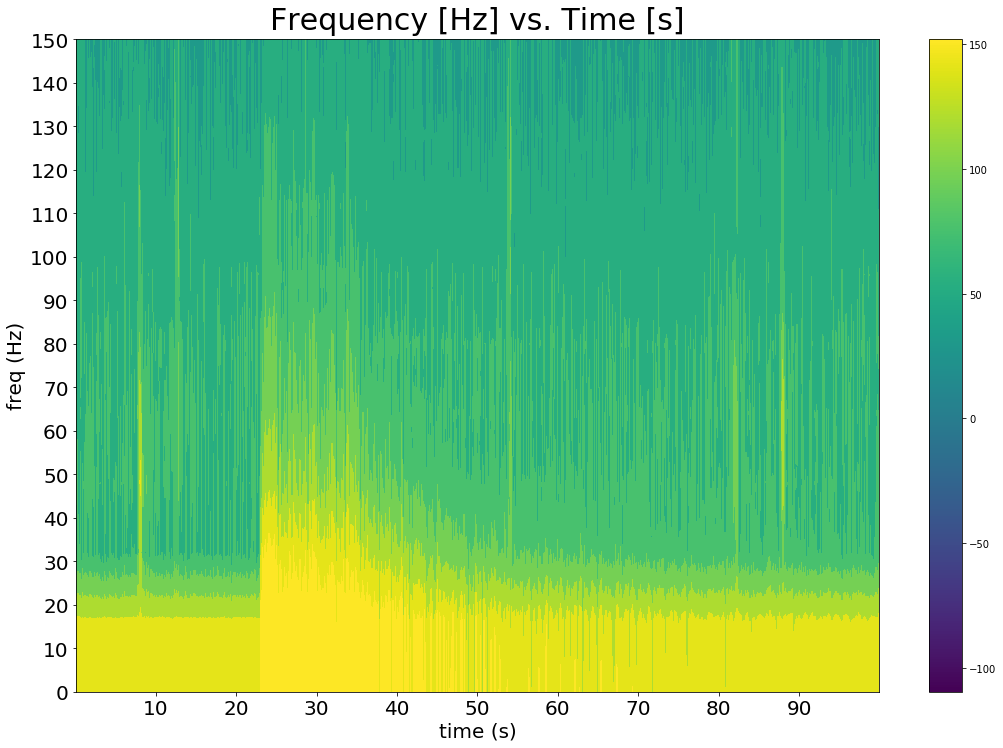

In [0]:
starttime3 = stSeis[0].stats.starttime+200 #100
endtime3 = stSeis[0].stats.starttime+300 #starttime+300
ylims3=(0,150) #Frequency range of seismic activity according to the Wenz curve
spectrogram(stSeis,ylims3,starttime3,endtime3)